In [1]:
# ## 2. Importar Librerías

# In[ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf # Necesario para funciones de backend de Keras si implementamos la pérdida

# Configure visualization style
sns.set_style("whitegrid")



C:\Users\ULTRA GAMING\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ## 3. Cargar Datos de Entrenamiento

# In[ ]:
# Define paths (ajusta si es necesario basado en la ubicación del notebook)
BASE_DATA_PATH = "../data/"
train_csv_path = os.path.join(BASE_DATA_PATH, "train-small.csv")

# Load the training dataframe
try:
    train_df = pd.read_csv(train_csv_path)
    print(f"Archivo CSV de entrenamiento cargado exitosamente desde: {train_csv_path}")
    print(f"Forma: {train_df.shape}")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo CSV: {e}")
    print(f"Asegúrate de que el archivo esté en la carpeta '{BASE_DATA_PATH}'")
    raise e

# Display first few rows
display(train_df.head())

Archivo CSV de entrenamiento cargado exitosamente desde: ../data/train-small.csv
Forma: (1000, 16)


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
## 4. Identificar Columnas de Etiquetas

# In[ ]:
# List of the 14 pathology labels
label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

# Verify the label columns exist in the dataframe
actual_label_cols = [col for col in label_cols if col in train_df.columns]
print(f"Columnas de etiquetas identificadas ({len(actual_label_cols)}): {actual_label_cols}")

# Ensure all expected label columns are present
if len(actual_label_cols) != len(label_cols):
     print("\n¡Advertencia! No todas las columnas de etiquetas esperadas se encontraron en el DataFrame.")
     missing_cols = set(label_cols) - set(actual_label_cols)
     print(f"Columnas faltantes: {missing_cols}")

# Convert labels to numeric (0 or 1) just in case
for col in actual_label_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)

Columnas de etiquetas identificadas (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
## 5. Calcular Frecuencias de Clases

# Necesitamos calcular la frecuencia de aparición de casos positivos (`freq_pos`) y negativos (`freq_neg`) para cada una de las 14 patologías en el conjunto de entrenamiento.

# In[ ]:
def compute_class_freqs(labels_df, label_columns):
    """
    Calcula la frecuencia de casos positivos y negativos para cada etiqueta.

    Args:
        labels_df (pd.DataFrame): DataFrame que contiene las etiquetas (0 o 1).
        label_columns (list): Lista de nombres de las columnas de etiquetas.

    Returns:
        dict: Un diccionario donde las claves son los nombres de las etiquetas
              y los valores son tuplas (freq_pos, freq_neg).
    """
    freqs = {}
    total_examples = len(labels_df)

    if total_examples == 0:
        return freqs # Return empty dict if dataframe is empty

    for label in label_columns:
        # Contar casos positivos (donde la etiqueta es 1)
        pos_count = labels_df[label].sum()
        # Contar casos negativos (donde la etiqueta es 0)
        neg_count = total_examples - pos_count

        # Calcular frecuencias
        freq_pos = pos_count / total_examples
        freq_neg = neg_count / total_examples

        freqs[label] = (freq_pos, freq_neg)

    return freqs

# Calcular las frecuencias para nuestro conjunto de entrenamiento
class_frequencies = compute_class_freqs(train_df, actual_label_cols)

# Mostrar las frecuencias calculadas
print("--- Frecuencias de Clase (Positivo, Negativo) ---")
for label, (freq_pos, freq_neg) in class_frequencies.items():
    print(f"- {label:<20}: Positivos={freq_pos:.4f}, Negativos={freq_neg:.4f}")


--- Frecuencias de Clase (Positivo, Negativo) ---
- Atelectasis         : Positivos=0.1060, Negativos=0.8940
- Cardiomegaly        : Positivos=0.0200, Negativos=0.9800
- Consolidation       : Positivos=0.0330, Negativos=0.9670
- Edema               : Positivos=0.0160, Negativos=0.9840
- Effusion            : Positivos=0.1280, Negativos=0.8720
- Emphysema           : Positivos=0.0130, Negativos=0.9870
- Fibrosis            : Positivos=0.0140, Negativos=0.9860
- Hernia              : Positivos=0.0020, Negativos=0.9980
- Infiltration        : Positivos=0.1750, Negativos=0.8250
- Mass                : Positivos=0.0450, Negativos=0.9550
- Nodule              : Positivos=0.0540, Negativos=0.9460
- Pleural_Thickening  : Positivos=0.0210, Negativos=0.9790
- Pneumonia           : Positivos=0.0100, Negativos=0.9900
- Pneumothorax        : Positivos=0.0380, Negativos=0.9620


C:\Users\ULTRA\AppData\Local\Temp\ipykernel_80284\1990169921.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_freqs_series.index, y=pos_freqs_series.values, palette="viridis")


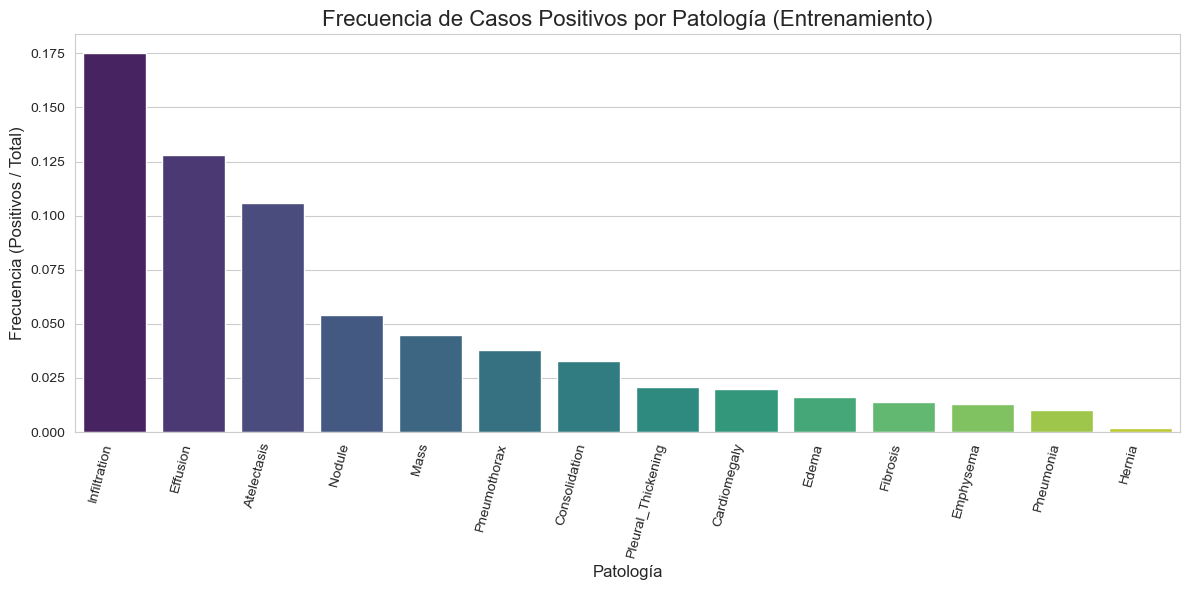

Este gráfico confirma visualmente el desbalance de clases observado anteriormente.


In [5]:
# Visualizar las frecuencias de casos positivos (similar al gráfico anterior)
pos_freqs_series = pd.Series({label: freq_pos for label, (freq_pos, _) in class_frequencies.items()})
pos_freqs_series = pos_freqs_series.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=pos_freqs_series.index, y=pos_freqs_series.values, palette="viridis")
plt.title('Frecuencia de Casos Positivos por Patología (Entrenamiento)', fontsize=16)
plt.xlabel('Patología', fontsize=12)
plt.ylabel('Frecuencia (Positivos / Total)', fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

print("Este gráfico confirma visualmente el desbalance de clases observado anteriormente.")


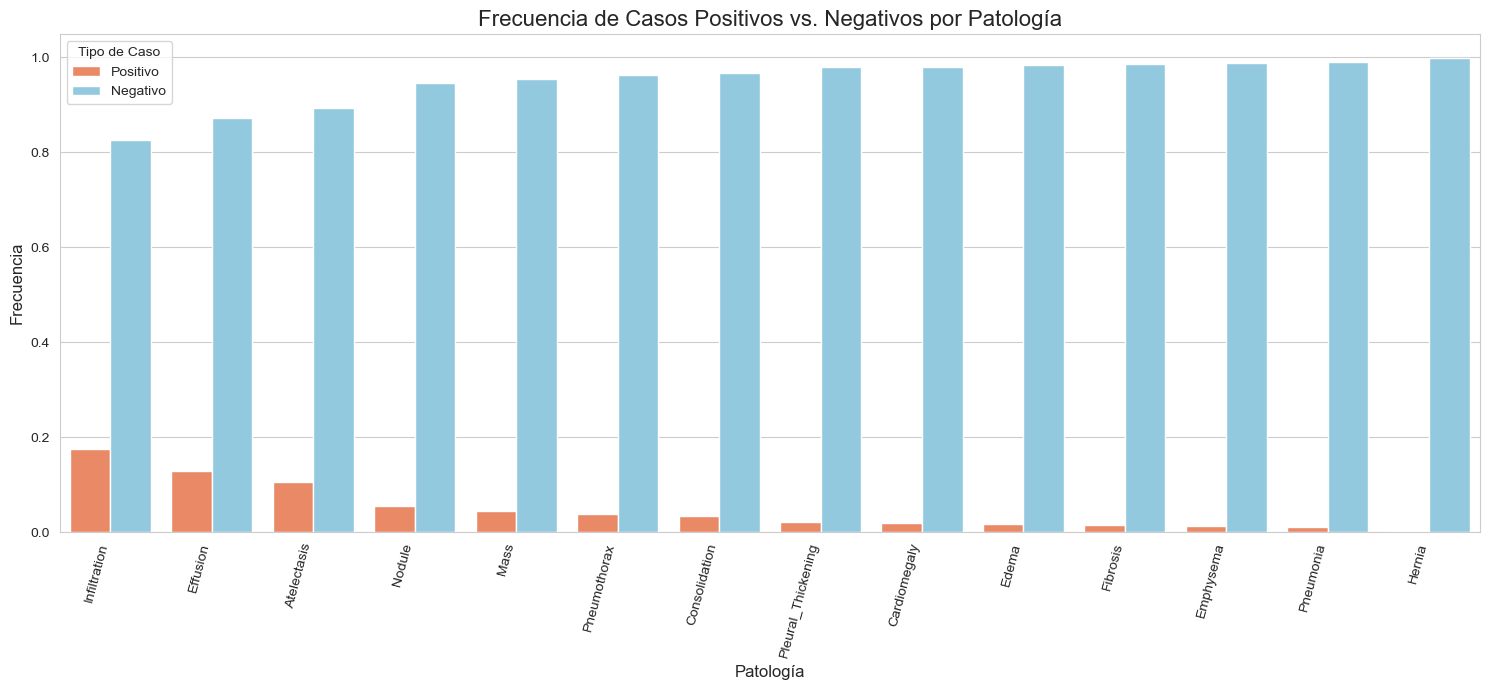


Observación del gráfico:
- Se evidencia claramente el gran desbalance: la barra 'Negativo' (azul) es mucho más alta que la 'Positivo' (coral) para casi todas las patologías.
- La suma de la frecuencia positiva y negativa para cada patología siempre es 1.0.


In [8]:
# **NUEVO GRÁFICO: Frecuencias Positivas vs. Negativas**
# Preparar datos para el gráfico combinado
freq_data = []
for label, (freq_pos, freq_neg) in class_frequencies.items():
    freq_data.append({'Patología': label, 'Tipo': 'Positivo', 'Frecuencia': freq_pos})
    freq_data.append({'Patología': label, 'Tipo': 'Negativo', 'Frecuencia': freq_neg})

freq_df = pd.DataFrame(freq_data)

# Ordenar por frecuencia positiva descendente para una mejor visualización
order = freq_df[freq_df['Tipo'] == 'Positivo'].sort_values('Frecuencia', ascending=False)['Patología']

# Crear el gráfico de barras agrupado
plt.figure(figsize=(15, 7))
sns.barplot(data=freq_df, x='Patología', y='Frecuencia', hue='Tipo', order=order, palette={'Positivo': 'coral', 'Negativo': 'skyblue'})
plt.title('Frecuencia de Casos Positivos vs. Negativos por Patología', fontsize=16)
plt.xlabel('Patología', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.legend(title='Tipo de Caso')
plt.tight_layout()
plt.show()

print("\nObservación del gráfico:")
print("- Se evidencia claramente el gran desbalance: la barra 'Negativo' (azul) es mucho más alta que la 'Positivo' (coral) para casi todas las patologías.")
print("- La suma de la frecuencia positiva y negativa para cada patología siempre es 1.0.")

In [6]:
 ## 6. Calcular Pesos para la Pérdida Ponderada

# Usaremos las frecuencias calculadas para determinar los pesos `w_pos` y `w_neg` para cada clase. La idea es que la contribución total de los positivos sea igual a la de los negativos. Una forma simple de lograr esto es:
#
# * `w_pos = freq_neg`
# * `w_neg = freq_pos`
#
# De esta manera, cuando multipliquemos la pérdida de un ejemplo positivo por `w_pos` y la de uno negativo por `w_neg`, y sumemos sobre todo el dataset, las contribuciones totales se equilibrarán.

# In[ ]:
def calculate_loss_weights(class_freqs):
    """
    Calcula los pesos w_pos y w_neg para cada clase basados en sus frecuencias.

    Args:
        class_freqs (dict): Diccionario con {label: (freq_pos, freq_neg)}.

    Returns:
        tuple: Dos diccionarios (pos_weights, neg_weights) donde las claves
               son los nombres de las etiquetas y los valores son los pesos.
    """
    pos_weights = {}
    neg_weights = {}

    for label, (freq_pos, freq_neg) in class_freqs.items():
        # Asignar pesos inversos a las frecuencias
        # w_pos = freq_neg
        # w_neg = freq_pos

        # Evitar división por cero si una clase tiene frecuencia 0 (aunque no debería pasar con neg_freq)
        # Si freq_pos es 0, freq_neg será 1. Si freq_neg es 0, freq_pos será 1.
        pos_weights[label] = freq_neg
        neg_weights[label] = freq_pos

        # Nota: A veces se usan otras formulaciones como 1/freq, pero esta es directa
        # para balancear la contribución total.

    return pos_weights, neg_weights

# Calcular los pesos
pos_weights, neg_weights = calculate_loss_weights(class_frequencies)

# Mostrar los pesos calculados
print("--- Pesos Calculados para Pérdida Ponderada ---")
print("(w_pos = freq_neg, w_neg = freq_pos)")
for label in actual_label_cols:
    w_p = pos_weights.get(label, 0) # Get weight, default 0 if label missing
    w_n = neg_weights.get(label, 0)
    print(f"- {label:<20}: w_pos={w_p:.4f}, w_neg={w_n:.4f}")

print("\nObservación:")
print("- Las clases raras (ej. Hernia) tienen un w_pos alto y un w_neg bajo.")
print("- Las clases comunes (ej. Infiltration) tienen un w_pos bajo y un w_neg alto.")


--- Pesos Calculados para Pérdida Ponderada ---
(w_pos = freq_neg, w_neg = freq_pos)
- Atelectasis         : w_pos=0.8940, w_neg=0.1060
- Cardiomegaly        : w_pos=0.9800, w_neg=0.0200
- Consolidation       : w_pos=0.9670, w_neg=0.0330
- Edema               : w_pos=0.9840, w_neg=0.0160
- Effusion            : w_pos=0.8720, w_neg=0.1280
- Emphysema           : w_pos=0.9870, w_neg=0.0130
- Fibrosis            : w_pos=0.9860, w_neg=0.0140
- Hernia              : w_pos=0.9980, w_neg=0.0020
- Infiltration        : w_pos=0.8250, w_neg=0.1750
- Mass                : w_pos=0.9550, w_neg=0.0450
- Nodule              : w_pos=0.9460, w_neg=0.0540
- Pleural_Thickening  : w_pos=0.9790, w_neg=0.0210
- Pneumonia           : w_pos=0.9900, w_neg=0.0100
- Pneumothorax        : w_pos=0.9620, w_neg=0.0380

Observación:
- Las clases raras (ej. Hernia) tienen un w_pos alto y un w_neg bajo.
- Las clases comunes (ej. Infiltration) tienen un w_pos bajo y un w_neg alto.


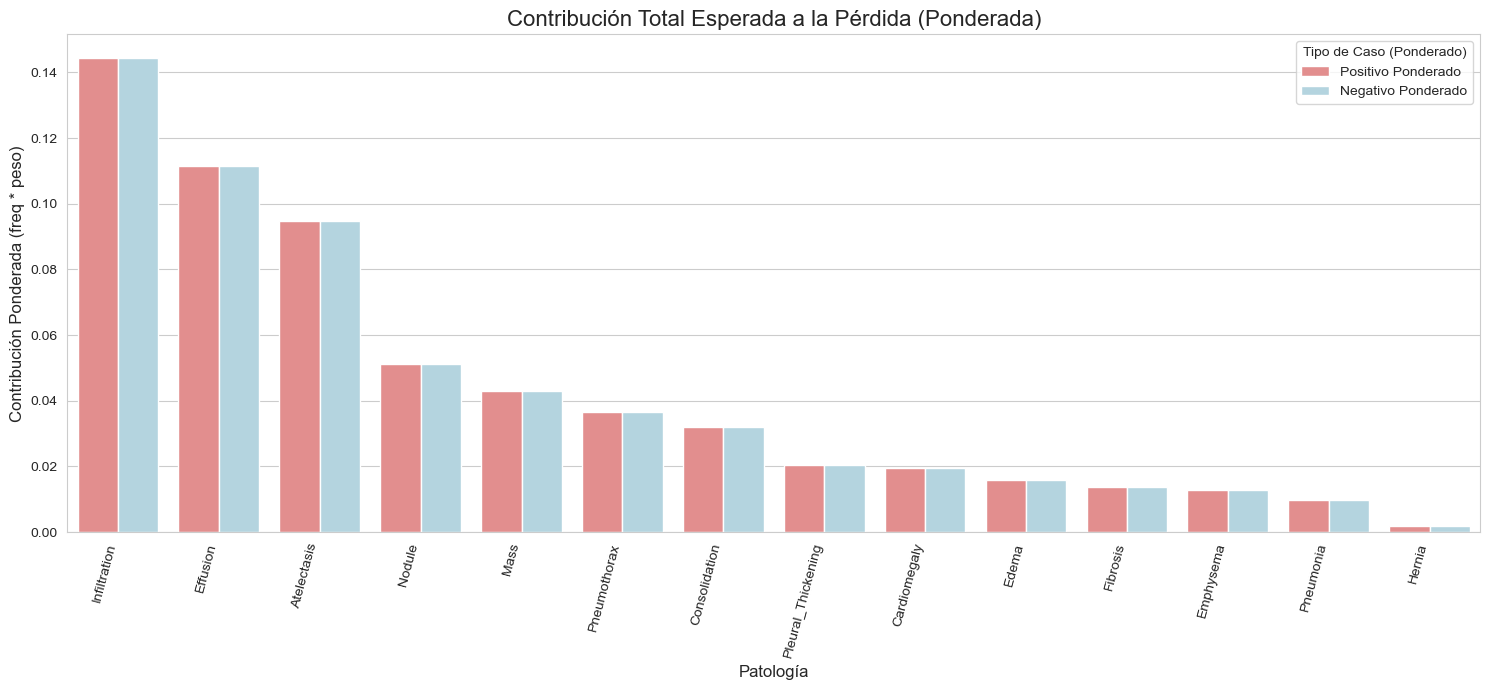


Observación del gráfico:
- Después de aplicar la ponderación (w_pos=freq_neg, w_neg=freq_pos), la contribución total esperada de los casos positivos y negativos a la función de pérdida es **igual** para cada patología.
- Esto demuestra cómo la ponderación equilibra el impacto de cada clase en la optimización del modelo, independientemente de su frecuencia original.


In [9]:
# **NUEVO GRÁFICO: Contribución Ponderada Esperada**
# Calcular la contribución ponderada esperada para cada tipo de caso
weighted_contribution_data = []
for label in actual_label_cols:
    freq_pos, freq_neg = class_frequencies[label]
    w_p = pos_weights[label]
    w_n = neg_weights[label]

    # Contribución total esperada de los positivos = freq_pos * w_pos
    total_pos_contrib = freq_pos * w_p
    # Contribución total esperada de los negativos = freq_neg * w_neg
    total_neg_contrib = freq_neg * w_n

    weighted_contribution_data.append({'Patología': label, 'Tipo': 'Positivo Ponderado', 'Contribución': total_pos_contrib})
    weighted_contribution_data.append({'Patología': label, 'Tipo': 'Negativo Ponderado', 'Contribución': total_neg_contrib})

weighted_contrib_df = pd.DataFrame(weighted_contribution_data)

# Crear el gráfico de barras agrupado para las contribuciones ponderadas
plt.figure(figsize=(15, 7))
# Usamos el mismo orden que el gráfico de frecuencias para consistencia
sns.barplot(data=weighted_contrib_df, x='Patología', y='Contribución', hue='Tipo', order=order, palette={'Positivo Ponderado': 'lightcoral', 'Negativo Ponderado': 'lightblue'})
plt.title('Contribución Total Esperada a la Pérdida (Ponderada)', fontsize=16)
plt.xlabel('Patología', fontsize=12)
plt.ylabel('Contribución Ponderada (freq * peso)', fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.legend(title='Tipo de Caso (Ponderado)')
plt.tight_layout()
plt.show()

print("\nObservación del gráfico:")
print("- Después de aplicar la ponderación (w_pos=freq_neg, w_neg=freq_pos), la contribución total esperada de los casos positivos y negativos a la función de pérdida es **igual** para cada patología.")
print("- Esto demuestra cómo la ponderación equilibra el impacto de cada clase en la optimización del modelo, independientemente de su frecuencia original.")